In [79]:
import numpy as np
import pandas as pd
from scipy.stats import nbinom, zipf
from scipy import interpolate
from scipy.stats import entropy

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from powerlaw import Fit

In [68]:
# generate dummy data using Zipf distribution with duplicates
n = 1000000
freq_obs = zipf.rvs(2, size=n)

df = pd.read_csv('../../projects/data/bolcom-clicks-35m_test.txt', sep='\t')
df


def create_index_df_from_column(argument_df, columnname):
    # create an index for the training item_ids, because we need this when training the model
    # this should be part of the train and serve code of an algorithm
    # usage:
    #     create_index_df_from_column(df, 'ItemId')
    # returns a two column dataframe:
    #   ItemId  idx
    #   9200000105095118    0
    #   9200000041902190    1
    #   9200000095595490    2
    token_id = {t: i for i, t in enumerate(argument_df[columnname].unique())}
    df_index = pd.DataFrame.from_dict(token_id, orient="index").reset_index()
    df_index.rename(columns={"index": columnname, 0: "idx"}, inplace=True)
    return df_index

item_pop_df = df.groupby('ItemId').size()
item_pops_df = item_pop_df.to_frame('qty').reset_index()
item_pops_df.sort_values(by=['qty'], inplace=True)
item_idx = create_index_df_from_column(item_pops_df, 'ItemId')
dfs = item_pops_df.merge(item_idx, on='ItemId')
dfs

freq_obs = dfs['qty'].to_numpy()

In [69]:
# Fit a powerlaw curve to the observed frequencies
fit = Fit(freq_obs, xmin=1)

In [83]:
# alpha be the scaling parameter of the distribution
# x_min be the lower bound
c, k = fit.power_law.alpha, fit.power_law.xmin

In [71]:
# Expand the distribution
m = 500000 # number of new items
new_idx_list = np.arange(len(freq_obs), len(freq_obs) + m)

In [72]:
p_obs = freq_obs / np.sum(freq_obs)
p_new = c / np.power(new_idx_list +1, k)

In [73]:
# Combine the observed and new item probabilities
p_all = np.concatenate([p_obs, p_new])
p_all = p_all / p_all.sum()
p_all = np.sort(p_all)

In [74]:
p_all

array([2.58601860e-07, 2.58601860e-07, 2.58601860e-07, ...,
       5.65303667e-04, 5.75130538e-04, 6.04093946e-04])

In [75]:
# Use linear interpolation to create a mapping between the cumulative probabilities and the item idx
cdf = np.cumsum(p_all)
prob_to_idx = interpolate.interp1d(cdf, np.arange(len(p_all)), kind='linear', bounds_error=False, fill_value=(p_all[0], p_all[-1]))


In [76]:
# Sample new items from the distribution
u = np.random.uniform(size=10)
idx = (np.rint(prob_to_idx(u))).astype(int)
samples = idx
        
# Print the samples and their probabilities
for item, freq in zip(*np.unique(samples, return_counts=True)):
    print(f"Sampled item {item} with frequency {freq / len(samples)}")

Sampled item 128034 with frequency 0.1
Sampled item 230219 with frequency 0.1
Sampled item 274131 with frequency 0.1
Sampled item 303042 with frequency 0.1
Sampled item 640466 with frequency 0.1
Sampled item 664173 with frequency 0.1
Sampled item 787821 with frequency 0.1
Sampled item 819370 with frequency 0.1
Sampled item 826990 with frequency 0.1
Sampled item 838263 with frequency 0.1


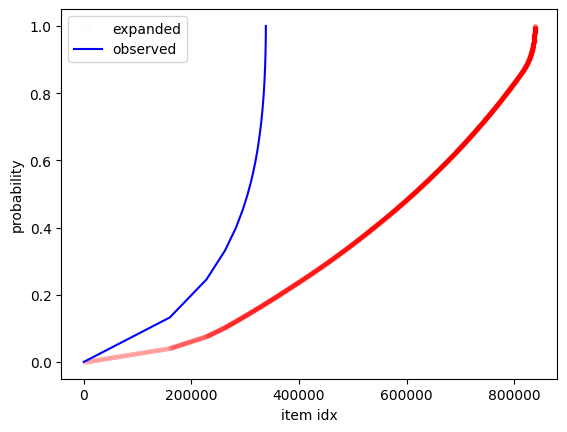

In [77]:
p_obs = np.sort(p_obs)
cdf_obs = np.cumsum(p_obs)    # cumulative distribution function of a random variable

max_i = 10000
u = [i/max_i for i in range(max_i + 1)]
X = (np.rint(prob_to_idx(u))).astype(int)
plt.scatter(X, u, marker='.', alpha=0.01,color='red',label='expanded')
plt.plot(range(len(cdf_obs)), cdf_obs,color='blue',label='observed')
plt.legend(loc='upper left')
plt.xlabel('item idx')
plt.ylabel('probability')
plt.show()

In [80]:
kl_divergence_obs_synth = entropy(p_obs, p_new[:len(p_obs)])
print(f"KL-divergence observed to synthetic: {kl_divergence_obs_synth}")
kl_divergence_synth_obs = entropy(p_new[:len(p_obs)], p_obs)
print(f"KL-divergence synthetic to observed: {kl_divergence_synth_obs}")


KL-divergence observed to synthetic: 1.0503205468926293
KL-divergence synthetic to observed: 0.7287387356334561


In [81]:
mae = np.mean(np.abs(p_obs - p_new[:len(p_obs)]))  # mean absolute error
rmse = np.sqrt(np.mean(np.square(p_obs - p_new[:len(p_obs)])))  # root mean squared error
ks = np.max(np.abs(np.cumsum(p_obs) - np.cumsum(p_new[:len(p_obs)])))  # Kolmogorov-Smirnov statistic
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, KS: {ks:.4f}")

MAE: 0.0000, RMSE: 0.0000, KS: 1.0685
